## Objective

1. Given data for the last N days of ETF pricing data, this model aims to predict for the N + H days in the future
2. Utilizing Prophet & LSTM as models to forecast time-series data

In [14]:
import pandas as pd
import numpy as np
import time
import math
import random
import matplotlib.pyplot as plt

from fbprophet import Prophet

In [2]:
# reading the dataset
# 5 years worth of pricing data
df = pd.read_csv('SPY.csv')

# convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

# remove spaces in col headers
df.columns = [str(i).lower().replace(' ','_') for i in df.columns]

# sort values by datetime
df.sort_values(by = 'date', inplace = True, ascending = True)

df.head()

,date,open,high,low,close,adj_close,volume
0,2015-06-15,208.639999,209.449997,207.789993,209.110001,189.227280,124384200
1,2015-06-16,208.929993,210.350006,208.720001,210.250000,190.258896,85308200
2,2015-06-17,210.589996,211.320007,209.360001,210.589996,190.566559,126708600
3,2015-06-18,211.309998,213.339996,210.630005,212.779999,192.548340,165867900
4,2015-06-19,211.460007,211.550003,210.360001,210.809998,191.693558,130478700


Text(0, 0.5, 'USD')

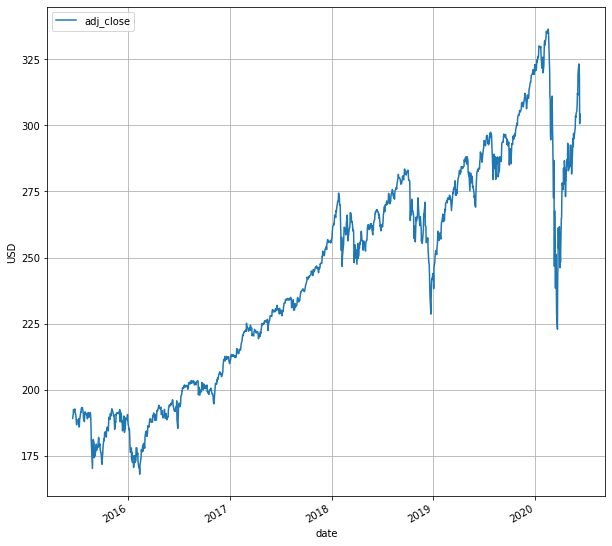

In [3]:
# Plot adjusted closing price of ETF over time
plt = df.plot(x = 'date', y = 'adj_close', figsize = [10,10], grid = True)
plt.set_ylabel('USD')

In [4]:
# Create new dataframe for Prophet
# Prophet always takes in 2 columns only, DS & Y
df_prophet = df[['date', 'adj_close']].rename(columns = {'date':'ds', 'adj_close':'y'})
df_prophet.tail()

,ds,y
1254,2020-06-08,323.200012
1255,2020-06-09,320.790009
1256,2020-06-10,319.000000
1257,2020-06-11,300.609985
1258,2020-06-12,304.209991


In [5]:
# based on historical data, we want to predict prices for the next 30 days, which will be the forecast horizon
H = 30

# 4 years of data to be training set
# typical year has around 253 trading days
train_size = 253*4

# 1 year to be validation set
test_size = 253

# size of both sets
train_test_size = train_size + test_size

In [6]:
# Fitting Prophet model
m = Prophet()
m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
# Create new dataframe with dates we want to predict
future = m.make_future_dataframe(periods = H)

In [8]:
# remove weekends from future dataframe, since we do not need to predict weekend data
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.weekday.html
# https://facebook.github.io/prophet/docs/non-daily_data.html

future['day'] = future['ds'].dt.weekday
future = future[future['day'] <5]

forecast = m.predict(future)

In [9]:
# check if we have values for future predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1274,2020-07-06,299.920586,287.582496,312.810941
1275,2020-07-07,300.550740,287.777923,313.024745
1276,2020-07-08,300.707556,288.431960,313.434286
1277,2020-07-09,301.050752,288.890643,312.992846
1278,2020-07-10,301.360097,289.395462,313.217647


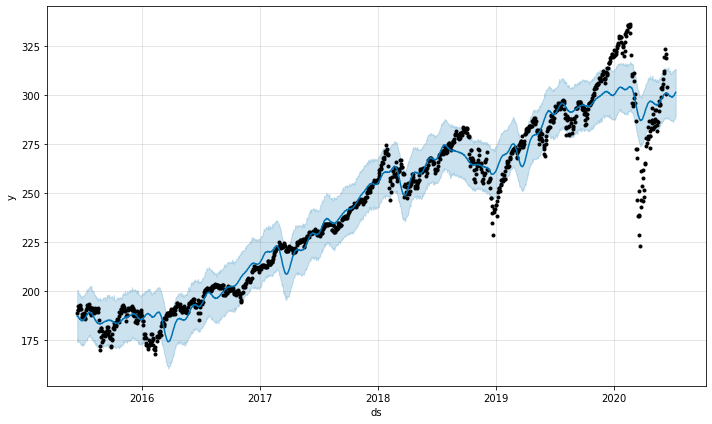

In [10]:
# plot the forecast
m.plot(forecast);

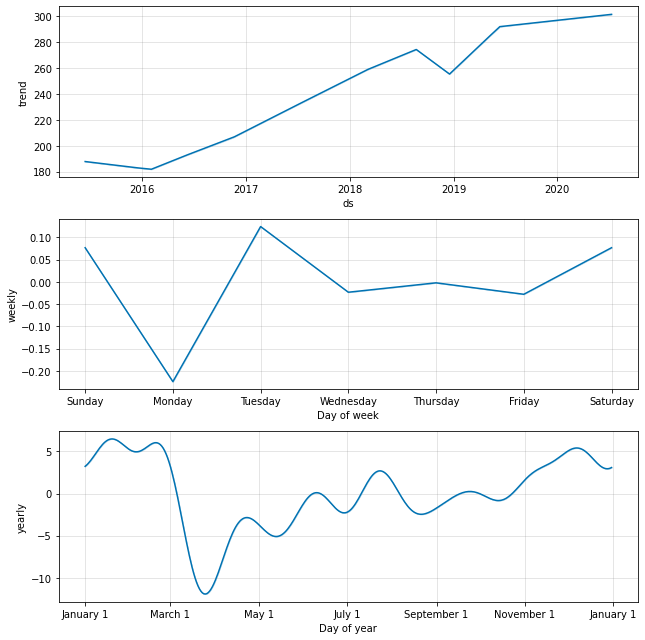

In [11]:
# plot components
m.plot_components(forecast);

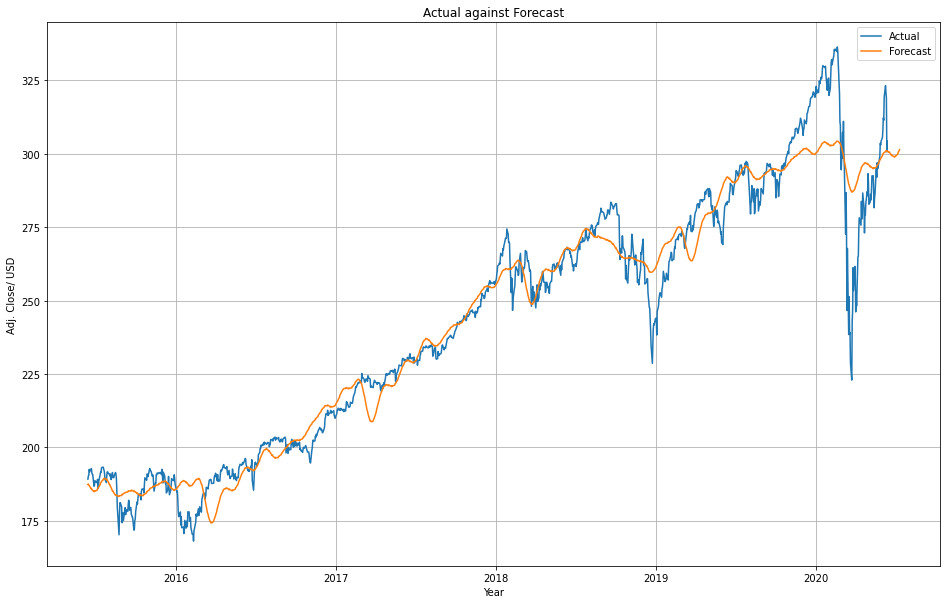

In [15]:
# Plotting the acutal plot against the forecast
plt.rcParams["figure.figsize"] = [16,10]
fig, ax = plt.subplots()
ax.plot('date','adj_close', data = df)
ax.plot('ds', 'yhat', data = forecast)

ax.set_title('Actual against Forecast')
ax.legend(['Actual','Forecast'])
ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Adj. Close/ USD')
ax.grid(True)
plt.show()

## Tweaking the model

From the plot above, forecast model does generally follow the acutal data, but we want to see if we can improve the prediciton accuracy of the Prophet model.

In [16]:
# Evaluating accuracy of time series model with error metrics 
# Use these metrics to evaluate our prediction accuracy

# MAPE - mean absolute percentage error
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE - mean absolute error
def get_mae(x, y):
    return np.mean(abs(np.array(x)-np.array(y)))

# RMSE - root mean squared error
def get_rmse(x, y):
    return math.sqrt(np.mean((np.array(x)-np.array(y))**2))

In [17]:
# Compare original dataframe and forecast model
print("MAPE: " + str(get_mape(df['adj_close'], forecast['yhat'][:-20])) + '\n' +
      "MAE: " + str(get_mae(df['adj_close'], forecast['yhat'][:-20])) + '\n' +
      "RMSE: " + str(get_rmse(df['adj_close'], forecast['yhat'][:-20]))
)

MAPE: 2.694284813514794
MAE: 6.558316223460894
RMSE: 9.664222949035862


In [ ]:
# What to tune in Prophet
# https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
# https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

In [18]:
# Count number of models that can arise from these variables
# For Prophet, we will focus on tweaking the changepoints and seasonality together with Fourier order

from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'fourier_order':[1 , 2, 3, 4, 5],
               'changepoint_prior_scale':[0.05, 0.1, 0.5, 1, 1.5, 2],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
count = 0
for p in grid:
    count = count+1

print('Total Possible Models',count)

Total Possible Models 180


In [19]:
# Prophet model tuning
model_parameters = pd.DataFrame(columns = ['MAPE', 'MAE', 'RMSE', 'Parameters'])

start = time.time()
counter = 0

for p in grid:
    print(p)
    random.seed(10)
    m = Prophet(seasonality_mode = p['seasonality_mode'],
                          changepoint_prior_scale = p['changepoint_prior_scale'],
                          n_changepoints = p['n_changepoints'],
                          daily_seasonality = True,
                          weekly_seasonality = True,
                          yearly_seasonality = True, 
                          interval_width = 0.95)
    
    #iterate through fourier_order
    m.add_seasonality(name='monthly', period=H, fourier_order= int(p['fourier_order']))
                
    # fit our Prophet-ready dataframe
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods = H)
    
    # remove weekends from our dataframe
    future['day'] = future['ds'].dt.weekday
    future = future[future['day'] <5]
    forecast = m.predict(future)
    
    # compute error metrics
    MAPE = get_mape(df['adj_close'], forecast['yhat'][:-20])
    MAE = get_mae(df['adj_close'], forecast['yhat'][:-20])
    RMSE = get_rmse(df['adj_close'], forecast['yhat'][:-20])
    
    # increase counter
    counter +=1
    
    print("Model " + str(counter) + ' out of 180')
    model_parameters = model_parameters.append({'MAPE':MAPE, 'MAE':MAE, 'RMSE':RMSE, 'Parameters':p}, 
                                               ignore_index=True)
    
end = time.time()
print(end-start)

{'changepoint_prior_scale': 0.05, 'fourier_order': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Model 1 out of 180
{'changepoint_prior_scale': 0.05, 'fourier_order': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Model 2 out of 180
{'changepoint_prior_scale': 0.05, 'fourier_order': 1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Model 3 out of 180
{'changepoint_prior_scale': 0.05, 'fourier_order': 1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Model 4 out of 180
{'changepoint_prior_scale': 0.05, 'fourier_order': 1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Model 5 out of 180
{'changepoint_prior_scale': 0.05, 'fourier_order': 1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Model 6 out of 180
{'changepoint_prior_scale': 0.05, 'fourier_order': 2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Model 7 out of 180
{'changepoint_prior_scale': 0.05, 'fourier_order': 2, 'n_changepoints': 100, 'se

Model 63 out of 180
{'changepoint_prior_scale': 0.5, 'fourier_order': 1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Model 64 out of 180
{'changepoint_prior_scale': 0.5, 'fourier_order': 1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Model 65 out of 180
{'changepoint_prior_scale': 0.5, 'fourier_order': 1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Model 66 out of 180
{'changepoint_prior_scale': 0.5, 'fourier_order': 2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Model 67 out of 180
{'changepoint_prior_scale': 0.5, 'fourier_order': 2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Model 68 out of 180
{'changepoint_prior_scale': 0.5, 'fourier_order': 2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Model 69 out of 180
{'changepoint_prior_scale': 0.5, 'fourier_order': 2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Model 70 out of 180
{'changepoint_prior_scale': 0.5, 'fourier_order': 2, 'n_changepoin

Model 126 out of 180
{'changepoint_prior_scale': 1.5, 'fourier_order': 2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Model 127 out of 180
{'changepoint_prior_scale': 1.5, 'fourier_order': 2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Model 128 out of 180
{'changepoint_prior_scale': 1.5, 'fourier_order': 2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Model 129 out of 180
{'changepoint_prior_scale': 1.5, 'fourier_order': 2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Model 130 out of 180
{'changepoint_prior_scale': 1.5, 'fourier_order': 2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Model 131 out of 180
{'changepoint_prior_scale': 1.5, 'fourier_order': 2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Model 132 out of 180
{'changepoint_prior_scale': 1.5, 'fourier_order': 3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Model 133 out of 180
{'changepoint_prior_scale': 1.5, 'fourier_order': 3,

In [20]:
# Export results to CSV
model_parameters.to_csv('tuning_results.csv')

# Sort parameters by descending MAPE
model_parameters.sort_values(by = ['MAPE', 'MAE', 'RMSE'])

,MAPE,MAE,RMSE,Parameters
148,0.874434,2.145336,3.322878,"{'changepoint_prior_scale': 1.5, 'fourier_orde..."
152,0.877163,2.150851,3.326797,"{'changepoint_prior_scale': 2, 'fourier_order'..."
104,0.885244,2.170542,3.362566,"{'changepoint_prior_scale': 1, 'fourier_order'..."
164,0.885515,2.171942,3.315765,"{'changepoint_prior_scale': 2, 'fourier_order'..."
94,0.886216,2.173026,3.356026,"{'changepoint_prior_scale': 1, 'fourier_order'..."
...,...,...,...,...
11,2.684580,6.519931,9.603455,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
15,2.685583,6.526001,9.612602,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
29,2.698546,6.550108,9.625411,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
1,2.701108,6.562181,9.660320,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
